In [ ]:
#Importing needed libraries
import zipfile
from six.moves import urllib
import re
import os
import math
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import tensorflow as tf
from tensorflow.keras.applications import mobilenet_v2 as tf_mobilenet_v2
from tensorflow import keras
from tensorflow.keras import layers as tf_layers
from tensorflow.keras import callbacks as tf_callbacks
from tensorflow.keras import models as tf_models
from tensorflow.keras.layers.experimental import preprocessing
from sklearn import metrics as sk_metrics
from sklearn import model_selection as sk_model_selection
from sys import path

In [ ]:
LegoPath = os.path.join("lego data") #making a path for the data
LegoURL = 'https://github.com/yitz25/LEGO-Minifigures-CV/raw/main/lego_data.zip' #url for the data
def FetchData(lego_url=LegoURL, lego_path=LegoPath):  #function to fetch and extract data from the url
     if not os.path.isdir(lego_path):
         os.makedirs(lego_path)
     zip_path = os.path.join(lego_path, "lego.zip")
     urllib.request.urlretrieve(lego_url, zip_path)
     with zipfile.ZipFile(zip_path, 'r') as gw_zip:
         gw_zip.extractall(path=lego_path)

FetchData()

In [ ]:
#Paths for the directory, index (train and valid), test and metadata files
BASE_DIR = "/content/lego data"
PATH_INDEX = os.path.join(BASE_DIR, "index.csv")
PATH_TEST = os.path.join(BASE_DIR, "test.csv")
PATH_METADATA = os.path.join(BASE_DIR, "metadata.csv")

In [ ]:
#seeting seed to ensure reproducibility
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    os.environ["TF_DETERMINISTIC_OPS"] = "true"


set_seed(seed_value=42)

In [ ]:
#reading the index and test files
df_index = pd.read_csv(PATH_INDEX)
df_test = pd.read_csv(PATH_TEST)

#making a split in the index dataframe to make a train and valid set for the model
tmp_train, tmp_valid = sk_model_selection.train_test_split(df_index, test_size=0.3, random_state=42)

#fuction to get the paths for each image and the class that belongs to that image
def get_paths_and_targets(tmp_df):
    paths = tmp_df["path"].values
    paths = list(map(lambda x: os.path.join(BASE_DIR, x), paths))
    targets = tmp_df["class_id"].values

    return paths, targets

#establishing the paths and targets for the train, valid and test set
paths_train, targets_train = get_paths_and_targets(tmp_train)
paths_valid, targets_valid = get_paths_and_targets(tmp_valid)
paths_test, targets_test = get_paths_and_targets(df_test)

In [ ]:
#reading the metadata file to get the total number of classes
df_metadata = pd.read_csv(PATH_METADATA, encoding='latin-1')
n_classes = df_metadata.shape[0]
print("Number of classes: ", n_classes)

Number of classes:  38


In [ ]:
#Making a class to generate the data for the model
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(
        self, paths, targets, image_size=(224, 224), batch_size=64,
        shuffle=True, transforms=None, preprocess=None,
    ):
        # the list of paths to files
        self.paths = paths
        # the list with the true labels of each file
        self.targets = targets
        # images size
        self.image_size = image_size
        # batch size (the number of images)
        self.batch_size = batch_size
        # if we need to shuffle order of files
        # for validation we don't need to shuffle, for training - do
        self.shuffle = shuffle
        # Augmentations for our images. It is implemented with albumentations library
        self.transforms = transforms
        # Preprocess function for the pretrained model implemented with MobileNet V2 model
        self.preprocess = preprocess

        # Call function to create and shuffle (if needed) indices of files
        self.on_epoch_end()

    def on_epoch_end(self):
        # This function is called at the end of each epoch while training

        # Create as many indices as many files we have
        self.indexes = np.arange(len(self.paths))
        # Shuffle them if needed
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        # We need that this function returns the number of steps in one epoch

        # How many batches we have
        return len(self.paths) // self.batch_size


    def __getitem__(self, index):
        # This function returns batch of pictures with their labels

        # Take in order as many indices as our batch size is
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        # Take image file paths that are included in that batch
        batch_paths = [self.paths[k] for k in indexes]
        # Take labels for each image
        batch_y = [self.targets[k] - 1 for k in indexes]
        batch_X = []
        for i in range(self.batch_size):
            # Read the image
            img = cv2.imread(batch_paths[i])
            # Resize it to needed shape
            img = cv2.resize(img, self.image_size)
            # Convert image colors from BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Apply transforms
            if self.transforms:
                img = self.transforms(image=img)["image"]
            # Apply preprocess
            if self.preprocess:
                img = self.preprocess(img)

            batch_X.append(img)

        return np.array(batch_X), np.array(batch_y)

In [ ]:
#Function with the transformations to make Data Augmentation
def get_train_transforms():
    return A.Compose(
        [
            #Rotate a shift the image
            A.ShiftScaleRotate(
                p=1.0,
                shift_limit=(-0.1, 0.1),
                scale_limit=(-0.2, 0.2),
                rotate_limit=(-30, 30),
                border_mode=4
            ),
            #Adding black blocks in the image
            A.CoarseDropout(
                p=0.5,
                max_holes=100,
                max_height=50,
                max_width=50,
                min_holes=10,
                min_height=10,
                min_width=10,
                fill_value=0,
            ),
            #Adding white blocks in the image
            A.CoarseDropout(
                p=0.5,
                max_holes=100,
                max_height=50,
                max_width=50,
                min_holes=10,
                min_height=10,
                min_width=10,
                fill_value=255,
            ),
            #Making a horizontal flip to the image
            A.HorizontalFlip(p=0.5),

            #Making random brightness and contrast changes to the image
            A.RandomBrightnessContrast(
                p=0.5,
                brightness_limit=(-0.2, 0.2),
                contrast_limit=(-0.2, 0.2),
            ),
            #Making a blur to the image
            A.Blur(p=0.25),
        ],
        p=1.0
    )

In [ ]:
#Generate train data
train_generator = DataGenerator(
    paths_train,
    targets_train,
    batch_size= 4, #to prevent reading the entire data set and do it in batches
    image_size=(512,512),
    shuffle=True,
    transforms=get_train_transforms(), #making the transformations only in the train data
    preprocess=tf_mobilenet_v2.preprocess_input,
)

#Generate validation data
valid_generator = DataGenerator(
    paths_valid,
    targets_valid,
    image_size=(512,512),
    batch_size=1,
    shuffle=False,
    preprocess=tf_mobilenet_v2.preprocess_input,
)

#Generate test data
test_generator = DataGenerator(
    paths_test,
    targets_test,
    image_size=(512,512),
    batch_size=1,
    shuffle=False,
    preprocess=tf_mobilenet_v2.preprocess_input,
)

In [ ]:
#function to denormalize the images for visualization
def denormalize_image(image):
    return ((image + 1) * 127.5).astype(int)

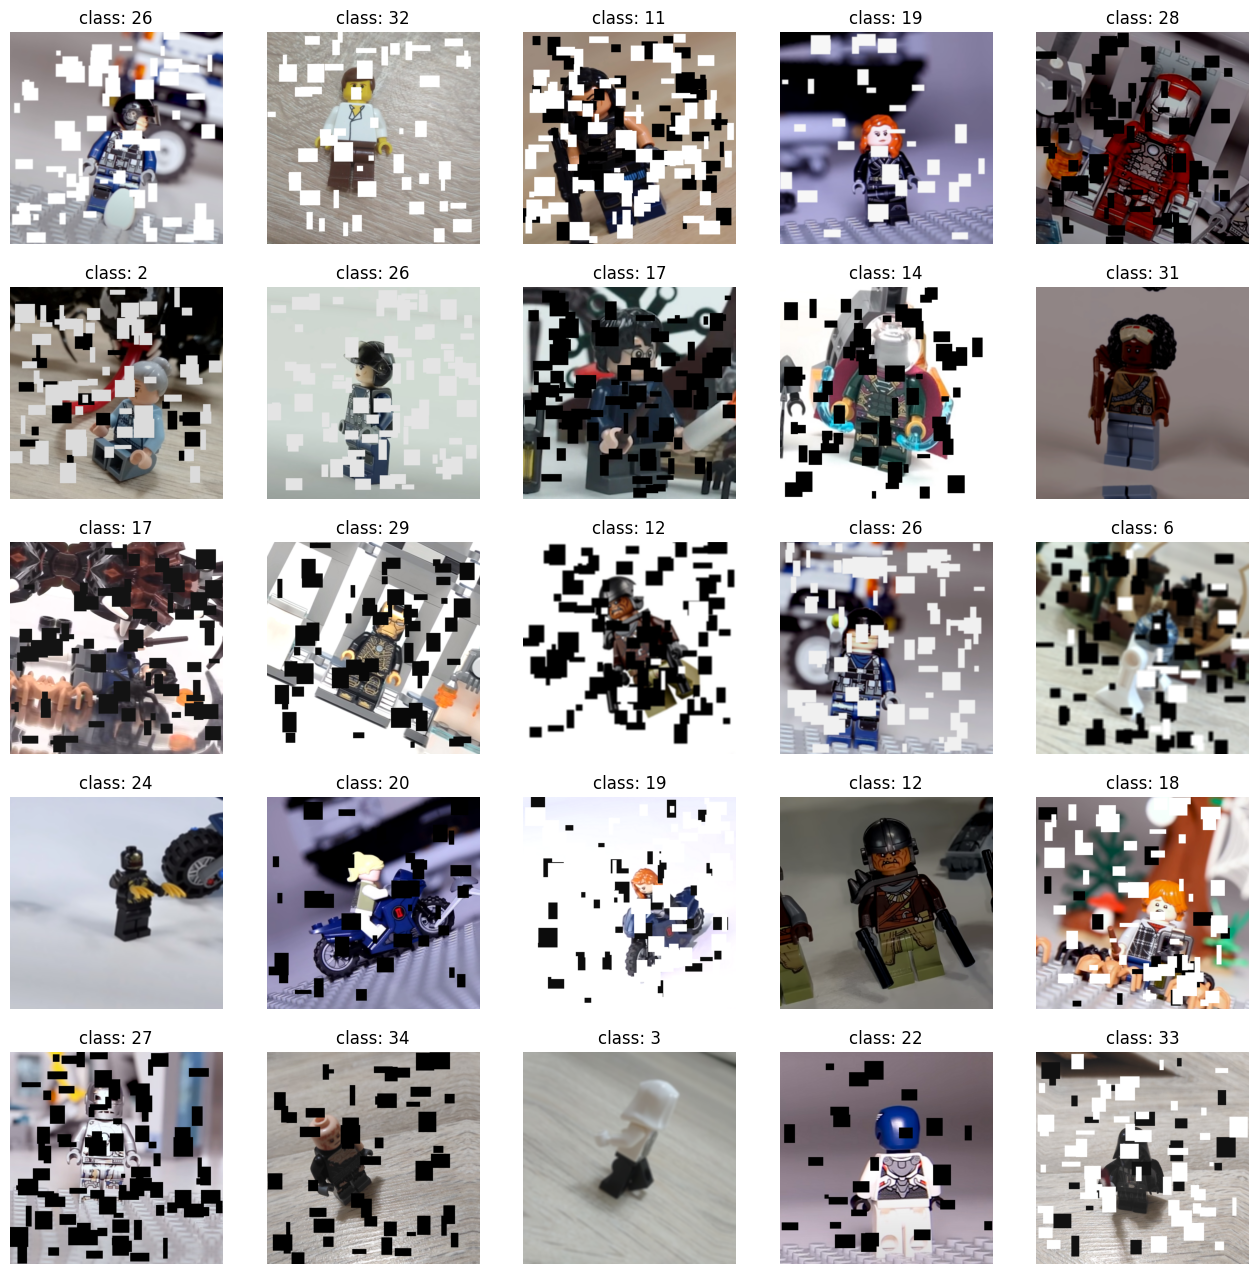

In [ ]:
#visualization of some examples in the traning data
plt.figure(figsize=(16, 16))
ind = 0
for i_batch in range(len(train_generator)):
    images, labels = train_generator[i_batch]
    for i in range(len(images)):
        plt.subplot(5, 5, ind + 1)
        ind += 1
        plt.imshow(denormalize_image(images[i]))
        plt.title(f"class: {labels[i]}")
        plt.axis("off")
        if ind >= 25:
            break
    if ind >= 25:
        break

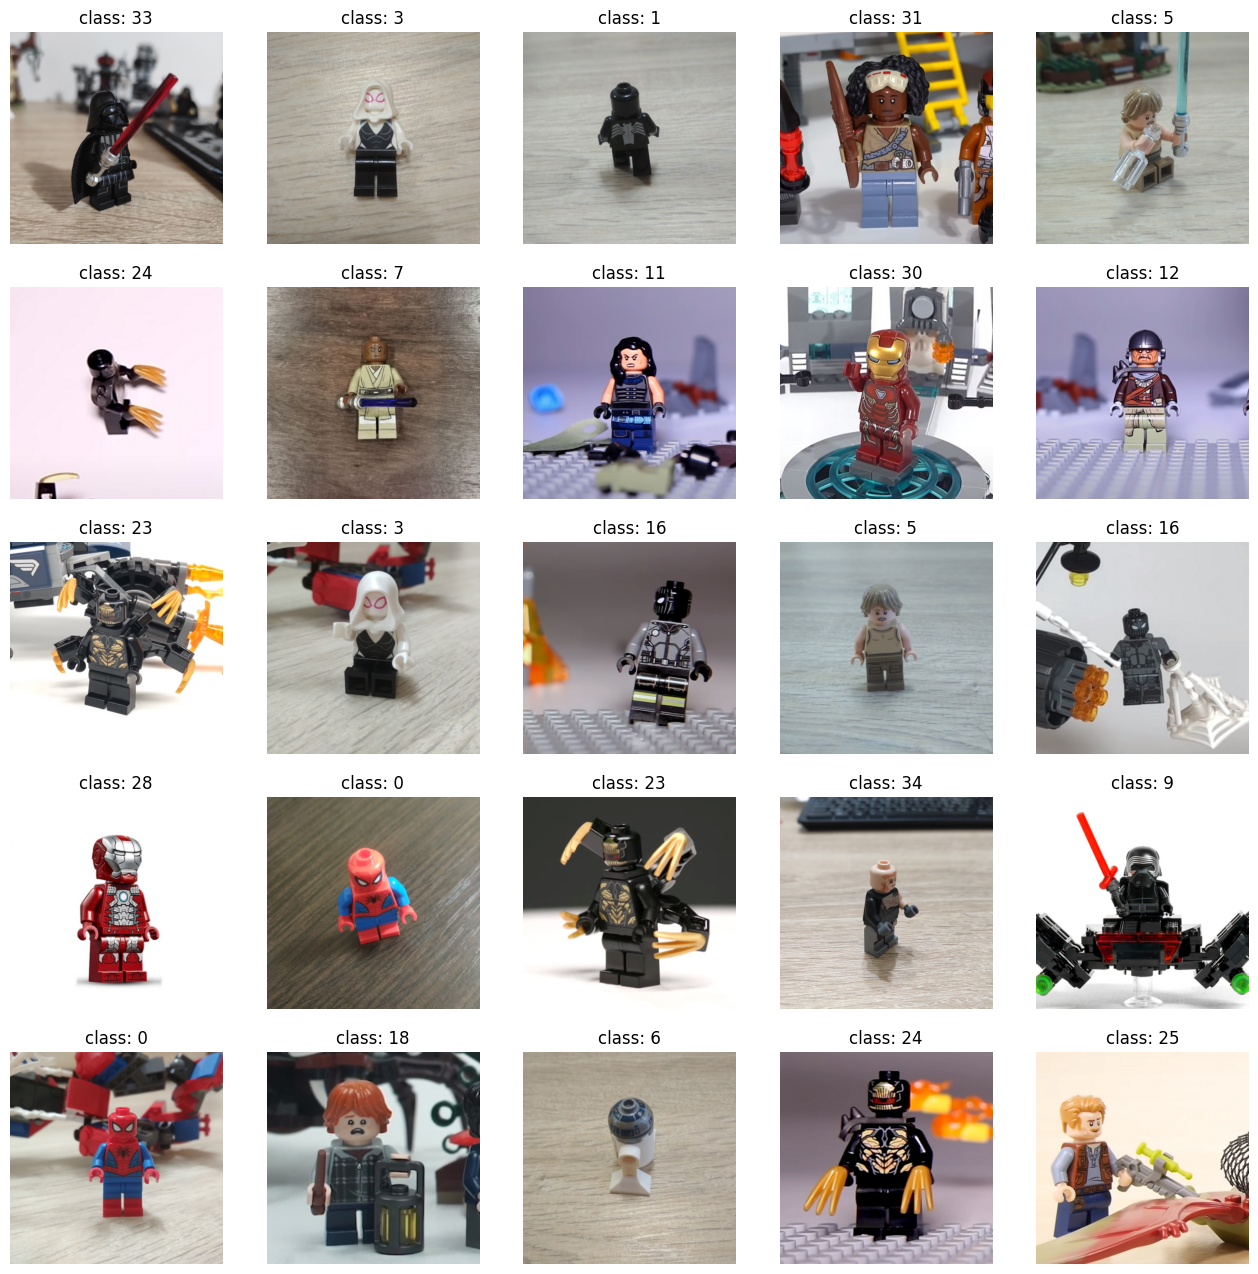

In [ ]:
#visualization of some examples in the validation data
plt.figure(figsize=(16, 16))
ind = 0
for i_batch in range(len(valid_generator)):
    images, labels = valid_generator[i_batch]
    for i in range(len(images)):
        plt.subplot(5, 5, ind + 1)
        ind += 1
        plt.imshow(denormalize_image(images[i]))
        plt.title(f"class: {labels[i]}")
        plt.axis("off")
        if ind >= 25:
            break
    if ind >= 25:
        break

In [ ]:
#Fetching the model MobileNet V2
base_model = tf_mobilenet_v2.MobileNetV2(input_shape=(512, 512, 3), include_top=False, weights='imagenet')
#Keeping the model freeze
base_model.trainable = False

#Creating the classification model
model = keras.Sequential([
    #Base
    base_model,
    #Head
    tf_layers.GlobalAveragePooling2D(),
    tf_layers.Dense(512, activation='relu'),
    tf_layers.Dropout(0.5),
    #Final layer with the same number of neurons as classes
    tf_layers.Dense(n_classes, activation='softmax')
])

In [ ]:
#Compiling the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(epsilon = 0.0001),
    metrics=['accuracy']
)

In [ ]:
#Callback to stop the model when there is no improve in validation loss in the last 3 epochs
callback_early_stopping = tf_callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
)

#Callback to save the best model for later use
callback_save = tf_callbacks.ModelCheckpoint(
    "best.hdf5",
    monitor='val_loss',
    save_best_only=True,
)

In [ ]:
#Fitting the model with a max of 50 epochs
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,
    callbacks=[callback_save, callback_early_stopping],
    verbose=1,
)

Epoch 1/50
64/64 [==============================] - ETA: 0s - loss: 4.1750 - accuracy: 0.0234

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 88s 1s/step - loss: 4.1750 - accuracy: 0.0234 - val_loss: 3.6129 - val_accuracy: 0.0536
Epoch 2/50
64/64 [==============================] - 82s 1s/step - loss: 3.6624 - accuracy: 0.0625 - val_loss: 3.5303 - val_accuracy: 0.0446
Epoch 3/50
64/64 [==============================] - 78s 1s/step - loss: 3.4890 - accuracy: 0.0859 - val_loss: 3.3862 - val_accuracy: 0.0625
Epoch 4/50
64/64 [==============================] - 78s 1s/step - loss: 3.3180 - accuracy: 0.0977 - val_loss: 3.2501 - val_accuracy: 0.0625
Epoch 5/50
64/64 [==============================] - 94s 1s/step - loss: 3.2436 - accuracy: 0.1016 - val_loss: 3.0832 - val_accuracy: 0.1518
Epoch 6/50
64/64 [==============================] - 101s 2s/step - loss: 3.1058 - accuracy: 0.1289 - val_loss: 3.0364 - val_accuracy: 0.0804
Epoch 7/50
64/64 [==============================] - 84s 1s/step - loss: 3.0684 - accuracy: 0.1289 - val_loss: 2.9209 - val_accuracy: 0.2411
Epoch 8/50
64/64 [============

In [ ]:
#Making the dataframe for the history of the model
history_frame = pd.DataFrame(history.history)

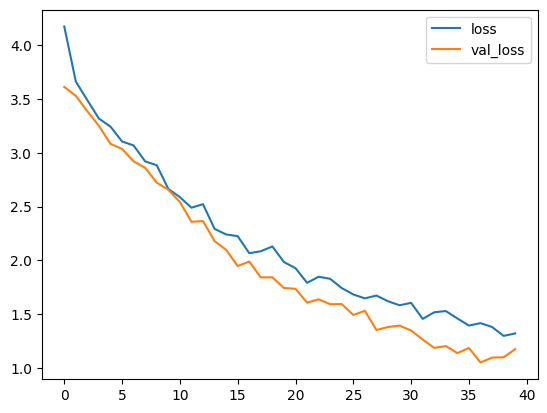

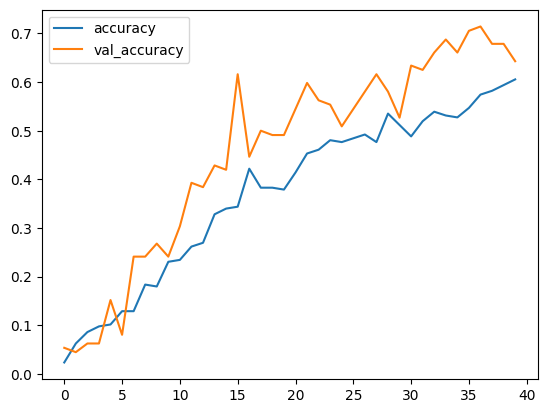

In [ ]:
#Plots to compare de loss and accuracy of the training and validation sets
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [ ]:
#Loading the best model
model = tf_models.load_model("best.hdf5")

In [ ]:
#Making the predictions with the model for the test set and saving the true labels
y_pred = []
y_test = []
for _X_test, _y_test in test_generator:
    y_pred.extend(model.predict(_X_test).argmax(axis=-1))
    y_test.extend(_y_test)

# Calculate needed metrics
print(f"Accuracy score on test data: {sk_metrics.accuracy_score(y_test, y_pred)}")
print(f"Macro F1 score on test data: {sk_metrics.f1_score(y_test, y_pred, average='macro')}")

1/1 [==============================] - 0s 161ms/step
Accuracy score on test data: 0.5949367088607594
Macro F1 score on test data: 0.5467322151532678


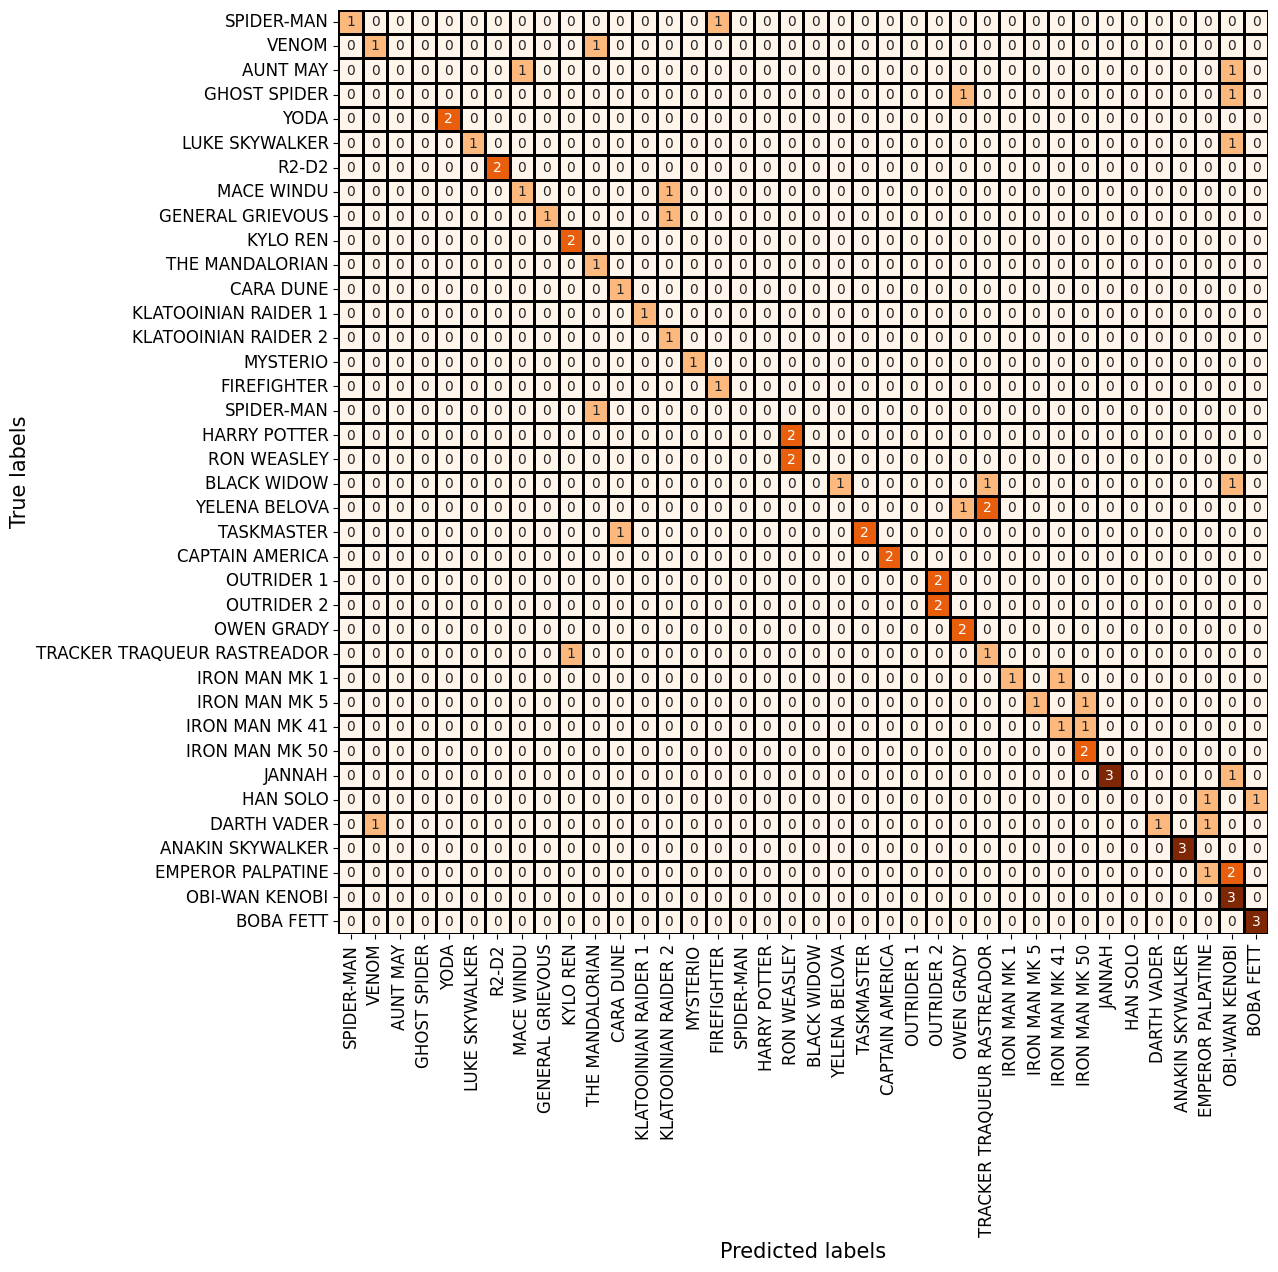

In [ ]:
# Load metadata to get classes people-friendly names
labels = df_metadata["minifigure_name"].tolist()

# Calculate confusion matrix
confusion_matrix = sk_metrics.confusion_matrix(y_test, y_pred)
df_confusion_matrix = pd.DataFrame(confusion_matrix, index=labels, columns=labels)

# Show confusion matrix
plt.figure(figsize=(12, 12))
sns.heatmap(df_confusion_matrix, annot=True, cbar=False, cmap="Oranges", linewidths=1, linecolor="black")
plt.xlabel("Predicted labels", fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel("True labels", fontsize=15)
plt.yticks(fontsize=12);

In [ ]:
#Getting the images with the wrong predicted label
error_images = []
error_label = []
error_pred = []
error_prob = []
for _X_test, _y_test in test_generator:
    pred = model.predict(_X_test).argmax(axis=-1)
    if pred[0] != _y_test:
        error_images.extend(_X_test)
        error_label.extend(_y_test)
        error_pred.extend(pred)
        error_prob.extend(model.predict(_X_test).max(axis=-1))

1/1 [==============================] - 0s 202ms/step


In [ ]:
#Ploting the images with wrong labels
w_size = 3
h_size = math.ceil(len(error_images) / w_size)
plt.figure(figsize=(16, h_size * 4))
for ind, image in enumerate(error_images):
    plt.subplot(h_size, w_size, ind + 1)
    plt.imshow(denormalize_image(image))
    pred_label = labels[error_pred[ind]]
    pred_prob = error_prob[ind]
    true_label = labels[error_label[ind]]
    plt.title(f"predict: {pred_label} ({pred_prob:.2f})\ntrue: {true_label}", fontsize=12)
    plt.axis("off")

NameError: name 'math' is not defined